# jMotif - Overfit Classification Model

Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
import rpy2

In [3]:
sns.set_style("whitegrid")

In [4]:
%matplotlib inline

In [5]:
%load_ext rpy2.ipython 

In [6]:
from pylab import *

In [7]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [8]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [9]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

Example: the first 30 buildings

In [10]:
temp.ix[:,:30].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40940 entries, 2010-01-01 08:00:00+00:00 to 2016-01-01 06:00:00+00:00
Data columns (total 30 columns):
Office_Cristina        8760 non-null float64
PrimClass_Jolie        8760 non-null float64
PrimClass_Jaylin       8760 non-null float64
Office_Jesus           8760 non-null float64
PrimClass_Uma          8760 non-null float64
UnivClass_Tamra        8760 non-null float64
PrimClass_Jayla        8760 non-null float64
PrimClass_Janiya       8760 non-null float64
PrimClass_Umar         8760 non-null float64
PrimClass_Janice       8760 non-null float64
Office_Jett            8760 non-null float64
UnivDorm_Una           8760 non-null float64
UnivLab_Paul           8760 non-null float64
Office_Jerry           8760 non-null float64
PrimClass_Uriah        8760 non-null float64
PrimClass_Ulysses      8760 non-null float64
Office_Lesa            8760 non-null float64
UnivDorm_Claudia       8760 non-null float64
UnivClass_Tammy        8760 non-nu

# Training a jMotif VSM Classifier using ALL of the buildings as the training set

This experiment will capture all of the structure using tf-idf and overfit a model for all the buildings.

In [11]:
%%R 
library(jmotif)
library(ggplot2)
library(scales)

/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: Rcpp

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [12]:
meta.primaryspaceusage.unique()

array(['Primary/Secondary Classroom', 'College Classroom', 'Office',
       'Dormitory', 'College Laboratory'], dtype=object)

In [13]:
def get_tempdata_perclass(temp, meta, primaryuse):
    df = temp[list(meta[(meta['primaryspaceusage'] == primaryuse)].index)]
    df_reset_axis = pd.DataFrame()
    for building in df.columns:
        sample = df[building].dropna().reset_index(drop=True)
        df_reset_axis[building] = sample
    return df_reset_axis.dropna()

In [14]:
office_data_lab = get_tempdata_perclass(temp, meta, "Office")
dorm_data_lab = get_tempdata_perclass(temp, meta, "Dormitory")
lab_data_lab = get_tempdata_perclass(temp, meta, "College Laboratory")
colclass_data_lab = get_tempdata_perclass(temp, meta, "College Classroom")
primsecclass_data_lab = get_tempdata_perclass(temp, meta, "Primary/Secondary Classroom")

In [15]:
office_data_lab.head()

,Office_Elizabeth,Office_Ellie,Office_Cristina,Office_Jesus,Office_Erik,Office_Evelyn,Office_Emer,Office_Elena,Office_Jett,Office_Jerry,...,Office_Pasquale,Office_Bryon,Office_Marcia,Office_Dorian,Office_Shelly,Office_Pauline,Office_Luann,Office_Milton,Office_Lane,Office_Cameron
0,3.159733,6.685650,3.825,1.4,7.020433,155.820508,19.492250,19.193808,1.7,4.5,...,67.591667,273.150,192.75,426.8835,64.0,122.086111,358.2,745.50,226.6,368.774994
1,3.167025,6.922733,3.375,1.2,6.969100,150.711650,19.690150,19.388675,1.4,4.1,...,68.791667,267.925,194.00,428.1145,65.0,121.118472,357.6,727.00,218.0,363.024994
2,3.167042,6.922733,3.425,1.5,7.264267,154.314050,20.217883,19.908275,1.6,4.2,...,67.566667,267.725,194.50,425.0000,65.0,121.186389,356.4,725.50,221.0,368.824997
3,2.748550,6.780483,3.525,1.2,6.956267,150.187667,20.052967,19.745900,1.4,4.1,...,68.208333,266.425,196.25,414.0000,65.0,132.981667,354.6,725.25,217.9,370.749985
4,2.233192,6.875317,3.750,1.6,7.020433,130.472683,19.954017,19.648475,1.5,4.1,...,67.408333,263.250,191.75,417.0000,64.0,145.533611,356.4,723.25,223.3,364.050003


In [16]:
office_data_lab.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Columns: 156 entries, Office_Elizabeth to Office_Cameron
dtypes: float64(156)
memory usage: 10.5 MB


In [17]:
office_data = office_data_lab.reset_index(drop=True).T.reset_index(drop=True)
dorm_data = dorm_data_lab.reset_index(drop=True).T.reset_index(drop=True)
lab_data = lab_data_lab.reset_index(drop=True).T.reset_index(drop=True)
colclass_data = colclass_data_lab.reset_index(drop=True).T.reset_index(drop=True)
primsecclass_data = primsecclass_data_lab.reset_index(drop=True).T.reset_index(drop=True)

In [18]:
office_data.head()

,0,1,2,3,4,5,6,7,8,9,...,8750,8751,8752,8753,8754,8755,8756,8757,8758,8759
0,3.159733,3.167025,3.167042,2.748550,2.233192,2.182017,2.196658,2.203950,2.207600,2.225867,...,2.419592,2.733933,2.711992,2.699192,2.699200,2.715642,2.701017,2.554833,2.532900,2.532908
1,6.685650,6.922733,6.922733,6.780483,6.875317,6.827900,6.780483,6.922733,6.685650,6.780483,...,10.668650,11.095400,12.375642,12.185983,12.660133,12.849800,12.849783,12.470483,12.944625,13.181692
2,3.825000,3.375000,3.425000,3.525000,3.750000,3.625000,4.300000,3.950000,3.425000,3.000000,...,3.675000,3.275000,2.900000,4.450000,4.000000,3.250000,2.525000,3.050000,2.550000,3.175000
3,1.400000,1.200000,1.500000,1.200000,1.600000,1.200000,1.000000,1.100000,2.200000,3.200000,...,2.200000,2.000000,2.200000,1.200000,1.400000,1.000000,1.000000,1.000000,1.000000,1.000000
4,7.020433,6.969100,7.264267,6.956267,7.020433,7.020433,7.046100,7.135933,6.635392,6.391508,...,9.279275,8.996925,8.958408,9.163783,9.664300,9.895308,10.100700,9.741325,9.369133,9.407633


In [19]:
office_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Columns: 8760 entries, 0 to 8759
dtypes: float64(8760)
memory usage: 10.4 MB


In [20]:
a = 5 # the SAX alphabet size
p = 6 # the PAA size
w = 24 # the sliding window size

In [21]:
%Rpush office_data
%Rpush dorm_data
%Rpush lab_data
%Rpush colclass_data
%Rpush primsecclass_data
%Rpush w
%Rpush p
%Rpush a

In [22]:
%R office_data <- as.matrix(office_data)
%R dorm_data <- as.matrix(dorm_data)
%R lab_data <- as.matrix(lab_data)
%R colclass_data <- as.matrix(colclass_data)
%R primsec_data <- as.matrix(primsecclass_data)

%R office_words <- manyseries_to_wordbag(office_data, w, p, a, "exact", 0.01)
%R dorm_words <- manyseries_to_wordbag(dorm_data, w, p, a, "exact", 0.01)
%R lab_words <- manyseries_to_wordbag(lab_data, w, p, a, "exact", 0.01)
%R colclass_words <- manyseries_to_wordbag(colclass_data, w, p, a, "exact", 0.01)
%R primsec_words <- manyseries_to_wordbag(primsec_data, w, p, a, "exact", 0.01)
%R tfidf = bags_to_tfidf(list("Office" = office_words, "Dorm" = dorm_words, "Lab" = lab_words, "ColClass" = colclass_words, "PrimSec" = primsec_words))

,words,Office,Dorm,Lab,ColClass,PrimSec
0,aaacde,0.915277,0.000000,0.000000,0.354077,0.561199
1,aaaced,0.000000,0.000000,0.000000,0.000000,3.346732
2,aaaece,0.000000,0.000000,1.115577,0.000000,0.000000
3,aaaedc,0.000000,0.000000,0.000000,0.000000,1.115577
4,aabbed,0.000000,0.000000,0.000000,1.115577,0.000000
5,aabcec,0.154671,0.245148,0.245148,0.154671,0.000000
6,aabdeb,0.309343,0.309343,0.464014,0.000000,0.490296
7,aabebe,0.000000,0.000000,1.115577,0.000000,0.000000
8,aabecc,0.635124,0.000000,0.635124,0.000000,0.000000
9,aabecd,0.309343,0.000000,0.434217,0.434217,0.434217


In [23]:
%Rpull tfidf

In [24]:
tfidf.sort_values("Office", ascending=False).head()

,words,Office,Dorm,Lab,ColClass,PrimSec
438,aeddea,3.859264,0.000000,0.0,0.000000,0.000000
1231,ccdaad,2.590290,0.000000,0.0,0.000000,0.000000
1971,eaaedd,2.540497,0.000000,0.0,0.635124,0.000000
1229,cccecc,2.350239,0.000000,0.0,0.000000,2.197169
1893,deaaed,2.350239,0.635124,0.0,0.000000,0.000000


In [25]:
buildinglistlist = [[office_data_lab,"Office","Dorm","Lab","ColClass","PrimSec"], [dorm_data_lab,"Dorm","Office","Lab","ColClass","PrimSec"], 
                    [lab_data_lab,"Lab","Office","Dorm","ColClass","PrimSec"], [colclass_data_lab,"ColClass","Office","Dorm","Lab","PrimSec"],
                    [primsecclass_data_lab,"PrimSec","Dorm","Office","Lab","ColClass"]]

# Loop through all buildings and calculate the in-class specificity

In [26]:
inclass_specificity = pd.DataFrame(index=range(0,8759,1))
inclass_specificity_toplot = pd.DataFrame()
office_specificity = pd.DataFrame()
lab_specificity = pd.DataFrame()
colclass_specificity = pd.DataFrame()
primsecclass_specificity = pd.DataFrame()
dorm_specificity = pd.DataFrame()

overall_start_time = timeit.default_timer()

for buildinglist in buildinglistlist:
    print "Getting specificity for list whose first building is "+buildinglist[0].ix[0,:].index[0]
    start_time = timeit.default_timer()
    for building in buildinglist[0].columns:
        building_data = buildinglist[0][building].reset_index(drop=True).T.reset_index(drop=True)
        %Rpush building_data
        %R sample_bag = sax_via_window(building_data, w, p, a, "exact", 0.01)
        %R indexed_ordered = unlist(sample_bag)
        %R values = indexed_ordered
        %R time_index = attributes(indexed_ordered)$names
        %Rpull values
        %Rpull time_index
        
        time_index = pd.Series(time_index).astype("int")
        words = pd.DataFrame({building:values})
        orderedspec = pd.merge(words, tfidf, left_on=building, right_on='words', how='left')
        orderedspec.index = time_index
        last23hours = pd.DataFrame(columns=orderedspec.columns, index=range(8737,8760,1))
        orderedspec = pd.concat([orderedspec, last23hours])
        orderedspec = orderedspec.ffill(limit=24)
        
        inclass_specificity_building = orderedspec[buildinglist[1]] - orderedspec[buildinglist[2]] - orderedspec[buildinglist[3]] - orderedspec[buildinglist[4]] - orderedspec[buildinglist[5]]
        inclass_specificity_building = pd.DataFrame({building:inclass_specificity_building})
        inclass_specificity = pd.merge(inclass_specificity, inclass_specificity_building, right_index=True, left_index=True, how='outer')
            
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data_withindex = temp[building].tz_convert(timezone).truncate(before=start,after=end).tz_localize(None).ix[:8760]  
        
        inclass_specificity_building = inclass_specificity[building]
        inclass_specificity_building.index = building_data_withindex.index
        inclass_specificity_building_daily = pd.DataFrame({building:inclass_specificity_building.resample("D").mean()})
        inclass_specificity_toplot = pd.merge(inclass_specificity_toplot, inclass_specificity_building_daily, right_index=True, left_index=True, how='outer')

        
#         office_specificity[building] = orderedspec["Office"] - orderedspec["Dorm"] - orderedspec["Lab"] - orderedspec["ColClass"] - orderedspec["PrimSec"]
#         colclass_specificity[building] = orderedspec["ColClass"] - orderedspec["Dorm"] - orderedspec["Office"] - orderedspec["Lab"] - orderedspec["PrimSec"]
#         lab_specificity[building] = orderedspec["Lab"] - orderedspec["Dorm"] - orderedspec["Office"] - orderedspec["ColClass"] - orderedspec["PrimSec"]
#         primsecclass_specificity[building] = orderedspec["PrimSec"] - orderedspec["Dorm"] - orderedspec["Office"] - orderedspec["ColClass"] - orderedspec["Lab"]
#         dorm_specificity[building] = orderedspec["Dorm"] - orderedspec["Lab"] - orderedspec["Office"] - orderedspec["ColClass"] - orderedspec["PrimSec"]
        
    print "Calculated in "+str(timeit.default_timer() - start_time)+" seconds"

print "Calculated all buildings in "+str(timeit.default_timer() - overall_start_time)+" seconds"

Getting specificity for list whose first building is Office_Elizabeth
Calculated in 185.070511818 seconds
Getting specificity for list whose first building is UnivDorm_Una
Calculated in 89.3919980526 seconds
Getting specificity for list whose first building is UnivLab_Paul
Calculated in 118.900554895 seconds
Getting specificity for list whose first building is UnivClass_Clifford
Calculated in 105.436985016 seconds
Getting specificity for list whose first building is PrimClass_Everett
Calculated in 136.646562099 seconds
Calculated all buildings in 635.451753139 seconds


# Look at the Specificity of a single building

In [27]:
building = "Office_Ellie"

In [28]:
timezone = meta.T[building].timezone
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = temp[building].tz_convert(timezone).truncate(before=start,after=end).tz_localize(None).ix[:8760]


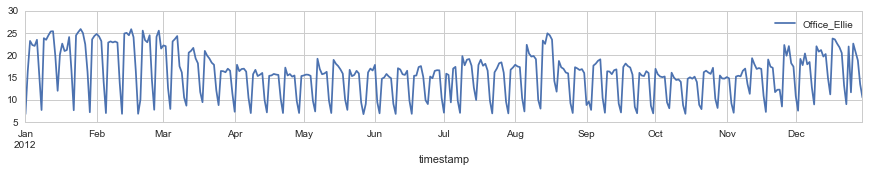

In [29]:
building_data = pd.DataFrame({building:building_data.resample("D").mean()})
building_data.plot(figsize=(15,2));

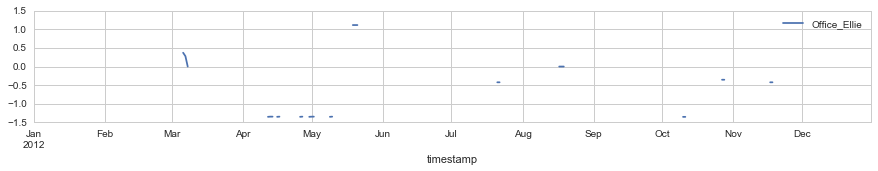

In [30]:
inclass_specificity_toplot_building = pd.DataFrame({building:inclass_specificity_toplot[building].truncate(before=start,after=end)})
inclass_specificity_toplot_building.plot(figsize=(15,2));

In [31]:
def get_individual_data(temp, meta, building):
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))

def get_individual_data_notz(temp, meta, building):
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    return pd.DataFrame(temp[building].truncate(before=start,after=end))

In [32]:
def plot_line_example(df_1, df_2, color, vartitle1, vartitle2):
    sns.set(rc={"figure.figsize": (12,4)})
    sns.set_style('whitegrid')
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    df_1.columns = ["Actual kWh"]
    #df_predicted.columns = ["Predicted kWh"]
    ax1 = fig.add_subplot(gs[1:60,:])
    df_1.plot(ax = ax1, legend=False) # .resample("D").sum()
    ax1.xaxis.set_visible(False)
    ax1.set_title(vartitle1)
    
    ax2 = fig.add_subplot(gs[68:,:])
    #df_2 = df_2.tz_localize(None)
    x = mdates.drange(df_2.index[0], df_2.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df_2.columns), len(df_2.columns)+1)
    data = np.array(df_2.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap)
    ax2.set_title(vartitle2)
    
    #leftspacing, 
    cbaxes = fig.add_axes([0.18, 0.08, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax2, orientation='horizontal', cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=7)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    ax2.axis('tight')
    ax2.xaxis_date()
    ax2.yaxis.set_visible(False)
    myFmt = mdates.DateFormatter('%b')
    ax2.xaxis.set_major_formatter(myFmt)

In [33]:
inclass_specificity_toplot_building_norm = (inclass_specificity_toplot_building - inclass_specificity_toplot_building.mean())/(inclass_specificity_toplot_building.max() - inclass_specificity_toplot_building.min())

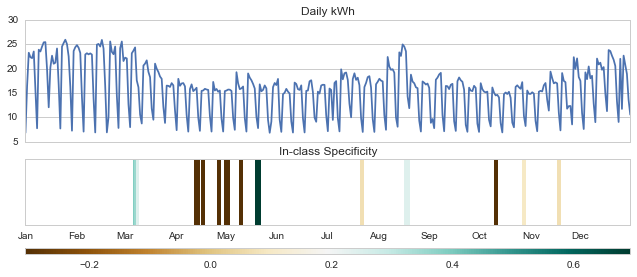

In [34]:
plot_line_example(building_data, inclass_specificity_toplot_building_norm, "BrBG","Daily kWh","In-class Specificity")
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/jmotif_alldatatrained_dailyspecificity_example_5_6_24.png"));

# Overview heatmap

In [35]:
def heatmap_data_weekday(df):
    x = np.linspace(0, len(df.index), len(df.index)+1)
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

def heatmap_data(df):
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    return x,y

#This function changes the year for all of the buildings so that they can be overlapped for plotting
# THE RESULTING DATAFRAME IS ONLY FOR "GENERALIZED" PLOTTING TO GET THE DATA SETS TO OVERLAP -- DON'T PERFORM CALCULATIONS ON IT

def changeto2015(x):
    try:
        return x.replace(year=2015)
    except:
        return np.nan
    
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & (s.index.month == 2) & (s.index.day == 29)

def generalize_timestamp_forplotting(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        timezone = meta.T[building].timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def generalize_timestamp_forplotting_notz(meta, temp):
    temp_generalized = pd.DataFrame()
    buildinglist = list(meta.index)
    
    for building in buildinglist:
        #Change to timezone
        start = meta.T[building].datastart
        end = meta.T[building].dataend
        building_data = pd.DataFrame(temp[building].truncate(before=start,after=end))
        
        #Remove leap year day for 2012
        mask = is_leap_and_29Feb(building_data)
        building_data = building_data.loc[~mask]
        
        #Change to 2015 -- we arbitrarily use this year
        building_data.index = building_data.index.map(lambda t: changeto2015(t))
        
        #Remove tz awareness, resample to normalize the timestamps and ffill to get rid of the gaps
        building_data = building_data.tz_localize(None)
        building_data = building_data.resample('D').mean().sort_index()
        building_data = building_data.ffill()
        
        #Merge into dataset
        temp_generalized = pd.merge(temp_generalized, building_data, right_index=True, left_index=True, how='outer')
        temp_generalized = temp_generalized.resample('D').mean().sort_index()
        
        #print "finished building: "+building
    return temp_generalized

def plotmap(df, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel):
    
    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    
    numberofplots = 1
    fig = plt.figure()
    
    x = mdates.drange(df.index[0], df.index[-1] + datetime.timedelta(days=1), datetime.timedelta(days=1))
    y = np.linspace(0, len(df.columns), len(df.columns)+1)
    ax = fig.add_subplot(numberofplots, 1, 1)
    data = np.array(df.T)
    datam = np.ma.array(data, mask=np.isnan(data))
    cmap = matplotlib.cm.get_cmap(color)
    qmesh = ax.pcolormesh(x, y, datam, cmap=cmap)
    
    cbaxes = fig.add_axes([0.15, 0.15, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax=cbaxes)
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)
    
    ax.axis('tight')
    ax.xaxis_date()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    ax.set_xlabel(xaxislabel)
    ax.set_ylabel(yaxislabel)
    ax.set_title(graphiclabel)
    
    ax.set_yticklabels(df.columns)
    tick_locator = ticker.MaxNLocator(nbins=110)
    loc = ticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    ax.locator_params(axis='y', nbins=100)
    myFmt = mdates.DateFormatter('%b')
    ax.xaxis.set_major_formatter(myFmt)
    
    plt.subplots_adjust(bottom=0.2)

def plotmap_subplots(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

    myFmt = mdates.DateFormatter('%b')
    months = MonthLocator()
    ax5.xaxis.set_major_locator(months)
    ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.6, yaxislabel, va='center', rotation='vertical')    

def plotmap_subplots_weekdays(df, meta, color, cbarlabel, xaxislabel, yaxislabel, graphiclabel, filelabel, z_min, z_max):

    import matplotlib.dates as mdates
    from matplotlib import ticker
    import datetime
    import matplotlib
    import seaborn as sns

    # Set up the size/style
    sns.set(rc={"figure.figsize": (12,15)})
    sns.set_style("whitegrid")
    cmap = matplotlib.cm.get_cmap(color)
    
    fig = plt.figure()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)
    gs = GridSpec(100,100,bottom=0.18,left=0.18,right=0.88)
    
    # Plot Offices
    df_office = df[df.columns[df.columns.str.contains("Office")]]
    office_height = int(len(df_office.T)/len(df.T)*100-2)
    ax1 = fig.add_subplot(gs[1:office_height,:])
    x,y = heatmap_data_weekday(df_office)
    data = np.array(df_office.T)
    datam = np.ma.array(data, mask=np.isnan(df_office))
    qmesh = ax1.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax1.axis('tight')
    #ax1.xaxis_date()
    ax1.set_title("Offices")
    ax1.xaxis.set_visible(False)
    
    # Plot UnivLab
    df_lab = df[df.columns[df.columns.str.contains("UnivLab")]]
    lab_height = int(len(df_lab.T)/len(df.T)*100-2)
    ax2 = fig.add_subplot(gs[office_height+2:office_height+lab_height,:])
    x,y = heatmap_data_weekday(df_lab)
    data = np.array(df_lab.T)
    datam = np.ma.array(data, mask=np.isnan(df_lab))
    qmesh = ax2.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax2.axis('tight')
    #ax2.xaxis_date()
    ax2.set_title("University Labs")
    ax2.xaxis.set_visible(False)
    
    # Plot UnivClass
    df_uniclass = df[df.columns[df.columns.str.contains("UnivClass")]]
    uniclass_height = int(len(df_uniclass.T)/len(df.T)*100-2)
    ax3 = fig.add_subplot(gs[office_height+lab_height+2:office_height+lab_height+uniclass_height,:])
    x,y = heatmap_data_weekday(df_uniclass)
    data = np.array(df_uniclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_uniclass))
    qmesh = ax3.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax3.axis('tight')
    #ax3.xaxis_date()
    ax3.set_title("University Classrooms")
    ax3.xaxis.set_visible(False)

    # Plot PrimClass
    df_primclass = df[df.columns[df.columns.str.contains("PrimClass")]]
    primclass_height = int(len(df_primclass.T)/len(df.T)*100-2)
    ax4 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+2:office_height+lab_height+uniclass_height+primclass_height,:])
    x,y = heatmap_data_weekday(df_primclass)
    data = np.array(df_primclass.T)
    datam = np.ma.array(data, mask=np.isnan(df_primclass))
    qmesh = ax4.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax4.axis('tight')
    #ax4.xaxis_date()
    ax4.set_title("Primary/Secondary Classroom")
    ax4.xaxis.set_visible(False)

    
    # Plot Univ Dorms
    df_unidorm = df[df.columns[df.columns.str.contains("UnivDorm")]]
    unidorm_height = int(len(df_unidorm.T)/len(df.T)*100-2)
    ax5 = fig.add_subplot(gs[office_height+lab_height+uniclass_height+primclass_height+2:office_height+lab_height+uniclass_height+primclass_height+unidorm_height,:])
    x,y = heatmap_data_weekday(df_unidorm)
    data = np.array(df_unidorm.T)
    datam = np.ma.array(data, mask=np.isnan(df_unidorm))
    qmesh = ax5.pcolormesh(x, y, datam, cmap=cmap, vmin=z_min, vmax=z_max)
    ax5.axis('tight')
    #ax5.xaxis_date()
    ax5.set_title("University Dorms")
    
    ax5.xaxis.set(ticks=np.arange(0.5, len(df_unidorm.index)), ticklabels=df_unidorm.index)
    
    cbaxes = fig.add_axes([0.18, 0.23, 0.7, 0.02]) 
    cbar = fig.colorbar(qmesh, orientation='horizontal', cax=cbaxes) #ax=ax,
    
    cbar.ax.tick_params(length = 0)
    cbar.set_label(cbarlabel)

#     myFmt = mdates.DateFormatter('%b')
#     months = MonthLocator()
#     ax5.xaxis.set_major_locator(months)
#     ax5.xaxis.set_major_formatter(myFmt)
    
    fig.text(0.14, 0.6, yaxislabel, va='center', rotation='vertical')

In [36]:
inclass_specificity_toplot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1706 entries, 2010-01-01 to 2015-12-31
Columns: 507 entries, Office_Elizabeth to PrimClass_Angel
dtypes: float64(507)
memory usage: 6.6 MB


In [37]:
inclass_specificity_toplot_generalized = generalize_timestamp_forplotting_notz(meta, inclass_specificity_toplot)


In [38]:
#inclass_specificity_toplot_generalized_sorted.mean()

In [39]:
inclass_specificity_toplot_generalized_norm = (inclass_specificity_toplot_generalized - inclass_specificity_toplot_generalized.min())/(inclass_specificity_toplot_generalized.max() - inclass_specificity_toplot_generalized.min())

In [40]:
inclass_specificity_toplot_generalized_norm_sorted = inclass_specificity_toplot_generalized_norm[list(inclass_specificity_toplot_generalized_norm.sum().sort_values().index)]

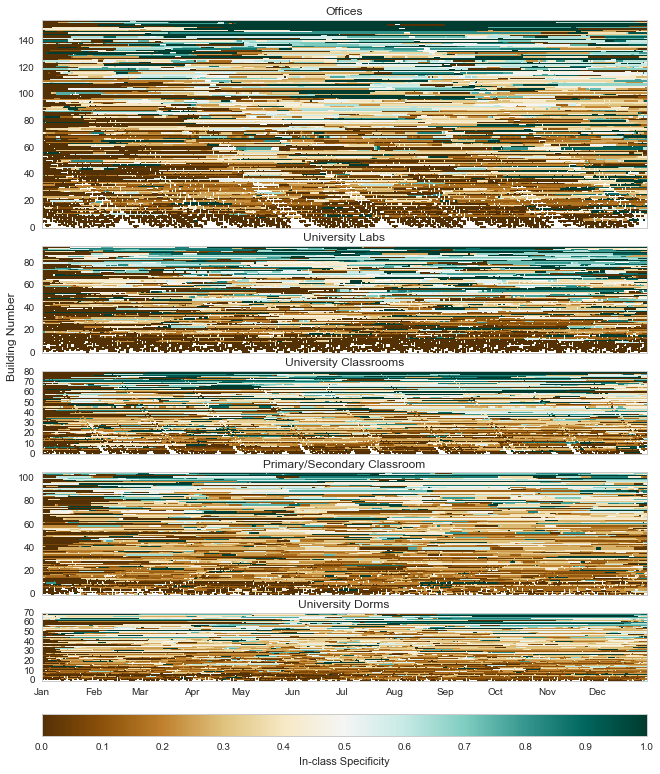

In [41]:
plotmap_subplots(inclass_specificity_toplot_generalized_norm_sorted, meta, 'BrBG', "In-class Specificity",
                 " ", "Building Number", " ", " ", 0, 1)
plt.savefig(os.path.join(repos_path,"reports/figures/featureoverviews/jmotif_inclassspec_allbuildings_heatmap_5_6_24.png"));